In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import os
import sys
import glob
from   astropy.io import fits
from   copy import deepcopy
from   scipy.special import logsumexp
from   scipy.interpolate import CubicSpline, UnivariateSpline, PchipInterpolator
import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano

PROJECT_DIR = '/Users/research/projects/kepler-ecc-rp/'

sys.path.append(PROJECT_DIR)
from utils.stats import weighted_percentile

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
#PATH = os.path.join(PROJECT_DIR, 'Results/20240829/alderaan-singles-LC-template/')
#PATH = os.path.join(PROJECT_DIR, 'Results/20240904/alderaan-multis-LC-template/')
PATH = os.path.join(PROJECT_DIR, 'Results/20241006/alderaan-all-LC-template/')
#PATH = os.path.join(PROJECT_DIR, 'Results/20241004/injection-test-template/')
files = list(np.sort(glob.glob(os.path.join(PATH, '*.fits'))))

# reorder to put master file (full population) at end of list
if len(files) > 1:
    master = [files[1]]
    files.pop(1)
    files = files + master

    # reverse order
    files.reverse()

In [3]:
files

['/Users/research/projects/kepler-ecc-rp/Results/20241006/alderaan-all-LC-template/20241006_ALDERAAN_alderaan-all-LC-template_histogram_npl_1_99_rpadj_0.5_16.0_per_1_100_rstar_0.7_1.4_000.fits']

## Load data

In [4]:
nfiles = len(files)

samples = [None]*nfiles
headers = [None]*nfiles
bin_edges = [None]*nfiles

for i, fname in enumerate(files):
    with fits.open(fname) as hduL:
        headers[i] = hduL[0].header
        data = hduL['SAMPLES'].data
        keys = data.names
        
        _samples = []
        for k in keys:
            _samples.append(data[k])
    
        samples[i] = pd.DataFrame(np.array(_samples).T, columns=keys)
        bin_edges[i] = np.array(hduL['BINEDGES'].data)

In [5]:
rp = np.zeros((len(samples),2), dtype='float')
ecc = np.zeros((len(samples),len(samples[0].mean_ecc)), dtype='float')
mult = np.zeros(len(samples), dtype='int')
nobj = np.zeros(len(samples), dtype='int')

for i, s in enumerate(samples):
    head = headers[i]
    
    rp[i]   = (head['RAD_0'], head['RAD_1'])
    ecc[i]  = s.mean_ecc.values
    mult[i] = head['MULT_1']
    nobj[i] = head['NOBJ']

## Template shape

In [6]:
def find_first_local_min_arg(y):
    n = len(y)
    for j in range(1,n-1):
        if (y[j] < y[j-1])*(y[j] < y[j+1]):
            return j

def find_first_local_max_arg(y):
    n = len(y)
    for j in range(1,n-1):
        if (y[j] > y[j-1])*(y[j] > y[j+1]):
            return j

#### Interpolate to uniform grid and enforce monotonicity

In [7]:
from scipy import stats

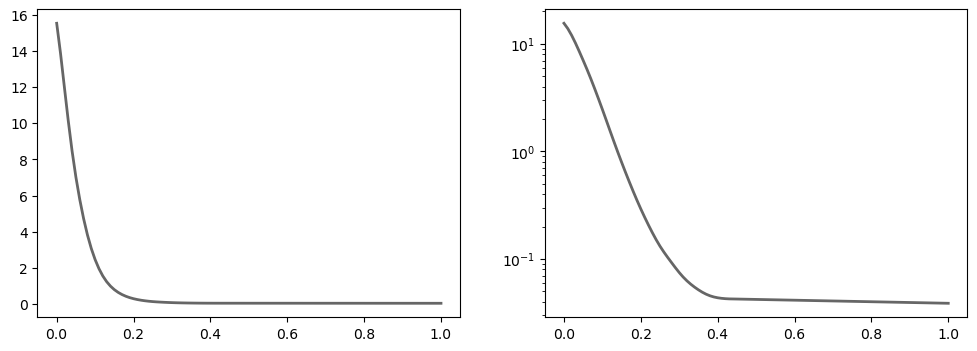

In [8]:
Nbin = 100
e_grid = np.linspace(0,1,Nbin+1)
ln_pdf = []

for i, s in enumerate(samples):
    # load ln_pdf amples
    lnp = s.filter(regex='ln_pdf')
    lnp = lnp.reindex(sorted(lnp.columns), axis=1)

    # raw values
    x_raw = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])
    y_raw = np.percentile(lnp, 50, axis=0)

    # interpolate to uniorm grid
    cspline = CubicSpline(x_raw, y_raw, extrapolate=True)
    x_grid = e_grid
    y_grid = cspline(x_grid)

    # enforce monotonicity
    ind = np.arange(len(y_grid), dtype='int')
    loc = find_first_local_min_arg(y_grid)    
    if loc is None:
        loc = len(y_grid)-1
    
    xmin = x_grid[loc]
    ymin = y_grid[loc]

    dx = 1./Nbin
    dy = y_grid[loc] - y_grid[loc-1]

    tangent = ymin + (dy/dx)*(x_grid-xmin)

    y_mono = y_grid.copy()
    y_mono[ind > loc] = tangent[ind > loc]

    # normalize
    y_norm = y_mono - logsumexp(y_mono + np.log(1/Nbin))
    
    # store pdf
    ln_pdf.append(y_norm)

#ln_pdf = np.array(ln_pdf)[::-1]

# make a plot
colors = ['k', 'C3', 'C1', 'C0', 'C2', 'C4']

fig, ax = plt.subplots(1,2, figsize=(12,4))
for i in range(2):
    for j in range(len(ln_pdf)):
        ax[i].plot(e_grid, np.exp(ln_pdf[j]), color=colors[j], alpha=0.6, lw=2)
ax[1].set_yscale('log')
plt.show()

#### Apply smoothing spline

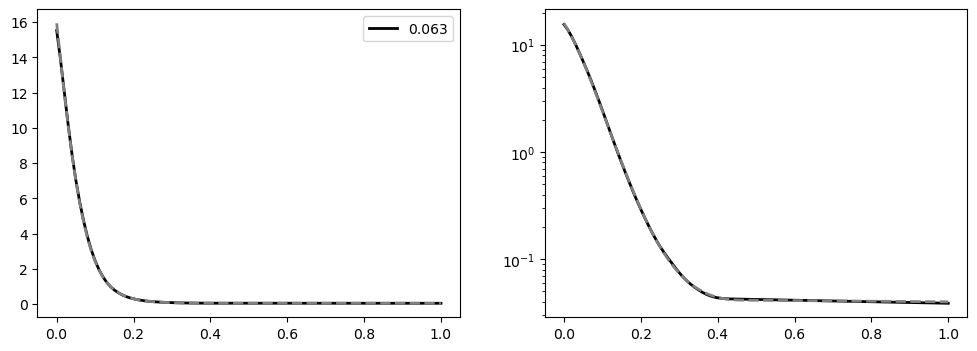

In [9]:
# mean and variance
ln_pdf_mean = np.average(ln_pdf, weights=nobj/np.sum(nobj), axis=0)
ln_pdf_var = np.average((ln_pdf-ln_pdf_mean)**2, weights=nobj/np.sum(nobj), axis=0)

# apply smoothing spline
y = UnivariateSpline(e_grid, ln_pdf_mean, s=1/Nbin)(e_grid)

# enforce monotonicity
loc = find_first_local_min_arg(y)
if loc is None:
    loc = len(y)-1

xmin = e_grid[loc]
ymin = y[loc]

dx = 1./Nbin
dy = y[loc] - y[loc-1]

tangent = ymin + (dy/dx)*(e_grid-xmin)
y[loc:] = tangent[loc:]

# smooth some wiggles in the tail
derivative = CubicSpline(e_grid, y).derivative(1)(e_grid)
loc = find_first_local_max_arg(derivative)

tangent = y[loc] + derivative[loc] * (e_grid - e_grid[loc])
y[loc:] = tangent[loc:]

# construct master template and normalize
ln_pdf_combo = y - logsumexp(y - np.log(Nbin))

# make a plot
colors = ['k', 'C3', 'C1', 'C0', 'C2', 'C4']
mean_ecc = np.mean(ecc, axis=1)

fig, ax = plt.subplots(1,2, figsize=(12,4))
for i in range(2):
    for j in range(len(ln_pdf)):
        if j == 0:
            ax[i].plot(e_grid, np.exp(ln_pdf[j]), color=colors[j], lw=2, 
                       label=mean_ecc[j].round(3))
        else:
            ax[i].plot(e_grid, np.exp(ln_pdf[j]), color=colors[j], alpha=0.6, 
                       label=mean_ecc[j].round(3))
            
    ax[i].plot(e_grid, np.exp(ln_pdf_combo), c='grey', ls='--', lw=2)
ax[0].legend()
ax[1].set_yscale('log')
plt.show()



## Ouput template file and plot for paper

In [10]:
np.savetxt(os.path.join(PROJECT_DIR, 'template_distribution.txt'), np.vstack([e_grid, ln_pdf_combo]).T)

## Manual interpolation

In [ ]:
x, y = np.loadtxt(os.path.join(PROJECT_DIR, 'template_distribution.txt')).T

template_spline = CubicSpline(x, y, extrapolate=False)

#### Using numpy

In [ ]:
bin_centers = x
b = 2.5

x_ = bin_centers*b
inds = np.searchsorted(template_spline.x[1:], x_)

coeffs = template_spline.c
coeffs = np.concatenate([coeffs.T, np.array([[0,0,0,template_spline(1)]])]).T
coeffs = coeffs[:,inds]

x_ = x_ - template_spline.x[inds]
x_ = np.stack([np.ones_like(x_), x_, x_**2, x_**3])[::-1]
y_ = np.sum(coeffs*x_, axis=0)

plt.figure(figsize=(4,3))
plt.plot(bin_centers, np.exp(y_), c='k')
plt.show()

#### Using aesara/theano

In [ ]:
bin_centers = x
b = 2.5

x_ = bin_centers*b
inds = T.TensorVariable.searchsorted(template_spline.x[1:], x_)

coeffs = theano.shared(template_spline.c)
coeffs = T.concatenate([coeffs.T, np.array([[0,0,0,template_spline(1)]])]).T
coeffs = coeffs[:,inds]

x_ = x_ - theano.shared(template_spline.x)[inds]
x_ = T.stack([T.ones_like(x_), x_, x_**2, x_**3])[::-1]
y_ = T.sum(coeffs*x_, axis=0)

plt.figure(figsize=(4,3))
plt.plot(bin_centers, np.exp(y_.eval()), c='k')
plt.show()